# Part 0:
## import everything
Run the cell below

In [1]:
import os
import glob, types
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
import sys
import pickle
import string
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
from scipy import stats
from scipy.ndimage.filters import gaussian_filter as smooth
import matplotlib.animation as animation
import matplotlib.backends.backend_pdf
import mpl_toolkits.axes_grid1.inset_locator as inset
from matplotlib.ticker import FormatStrFormatter, MaxNLocator, ScalarFormatter, FuncFormatter, PercentFormatter
from matplotlib.patches import ConnectionPatch, FancyArrowPatch, Arc
from set_rc_params import set_rc_params
import ROOT


if "__file__" not in dir():
    %matplotlib inline
    %config InlineBackend.close_figures = False

    root=ROOT.root
    
    ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
    CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
    CWD=os.getcwd()
    os.chdir(CommonNoteBookesPath)
    %run UtilityTools.ipynb
    %run Animal_Tags.ipynb
    %run loadRat_documentation.ipynb
    %run Lesion_Size.ipynb
    %run plotRat_documentation_1_GeneralBehavior.ipynb
    %run plotRat_documentation_3_KinematicsInvestigation.ipynb
    %run RunBatchRat_3_CompareGroups.ipynb
    %run BatchRatBehavior.ipynb
    currentNbPath=os.path.join(os.path.split(ThisNoteBookPath)[0],'LesionPaper','Lick.ipynb')
    %run $currentNbPath

    os.chdir(CWD)

    logging.getLogger().setLevel(logging.ERROR)
    
    param={
        "goalTime":7,#needed for pavel data only
        "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
        "maxTrialDuration":15,
        "interTrialDuration":10,#None pavel
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "cameraSamplingRate":25, #needed for new setup    

        "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
        "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
        "nbJumpMax":100,#200 pavel
        "binSize":0.25,
        #parameters used to preprocess (will override the default parameters)
    }
    Y1,Y2=param['treadmillRange']

    print('os:',OS(),'\nroot:',root,'\nImport successful!')

os: Linux 
root: /data 
Import successful!


---
---


# part 1:

# DEFINITIONS

### If you don't know what to do, move to part 2

In [ ]:
def add_panel_caption(axes: tuple, offsetX: tuple, offsetY: tuple, **kwargs):
    """
    This function adds letter captions (a,b,c,d) to Axes in axes
    at top left, with the specified offset, in RELATIVE figure coordinates
    """
    assert len(axes)==len(offsetX)==len(offsetY), 'Bad input!'
    
    fig=axes[0].get_figure()
    fbox=fig.bbox
    for ax,dx,dy,s in zip(axes,offsetX,offsetY,string.ascii_uppercase):
        axbox=ax.get_window_extent()
    
        ax.text(x=(axbox.x0/fbox.xmax)-abs(dx), y=(axbox.y1/fbox.ymax)+abs(dy),
                s=s,fontweight='extra bold', fontsize=10, ha='left', va='center',
               transform=fig.transFigure,**kwargs)

---

String Format for Scientific Notation

In [ ]:
def SciNote(string):
    """
    Format numbers with Real scientific notation
    Ex: 'p-val={}'.format(SciNote(p))
    """
    f = ScalarFormatter(useOffset=False, useMathText=True)
    g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.2e' % x))
    fmt = FuncFormatter(g)
    return fmt(string)

---

plotting group double errorbars for speed 

In [ ]:
def plot_event_1on1(root, ax, Profiles, colorCode, goodAnimals=None, TaskParamToPlot='% good trials',
                   x_pos=None, nPre=slice(-3,None), nPost=slice(0,3),nFin=slice(3,6),
                    seed=1, animal_plot=True):
    if goodAnimals is None:
        goodAnimals,sessionDict=event_detect(root, Profiles[0], Profiles[1])
    else:
        animalList,sessionDict=event_detect(root, Profiles[0], Profiles[1])
        sessionDict={animal:sessionDict[animal] for animal in goodAnimals}
    
    if x_pos is None:
        diff=.35
        x_c=ax.get_xlim()[1]
        x_pos=(x_c-diff,x_c,x_c+diff)
    diff=x_pos[1]-x_pos[0]
    
    #getting the data
    
    
    data=np.empty((len(goodAnimals),3))
    for i,animal in enumerate(goodAnimals):
        preSession,postSession=sessionDict[animal][0], sessionDict[animal][1]
        out=animal_learning_stats(root, animal, PerfParam=TaskParamToPlot,
                                  goodSessions=[*preSession,*postSession],redo=False)
        
        data[i,0]=np.nanmedian(out[:len(preSession)][nPre])
        data[i,1]=np.nanmedian(out[len(preSession):][nPost])
        data[i,2]=np.nanmedian(out[len(preSession):][nFin])
        
            
    
    y=np.nanpercentile(data,50,axis=0)
    yerr=np.nanpercentile(data,(25,75),axis=0)
    
    #plotting the errorbar
    ax.errorbar(x_pos, y, abs(yerr-y),fmt='-o', zorder=5, ms=3, elinewidth=1, color='k')
    
    #plotting individual animals
    if animal_plot:
        np.random.seed(seed=seed)
        _coeff=5000
        for i in range(data.shape[0]):
            if np.any(np.isnan(data[i,:])):
                continue
            jitPre =np.random.uniform(low=x_pos[0]-diff/_coeff, high=x_pos[0]+diff/_coeff, size=1)
            jitPost=np.random.uniform(low=x_pos[1]-diff/_coeff, high=x_pos[1]+diff/_coeff, size=1)
            jitFin =np.random.uniform(low=x_pos[2]-diff/_coeff, high=x_pos[2]+diff/_coeff, size=1)
            
            _,tag=lesion_type(root,animalList[i])
            c=colorCode[tag] if tag in colorCode else 'gray'

#             ax.scatter([jitPre,jitFin],data[i,[1,-1]], s=2, c=c, marker='o', edgecolors='none', alpha=.8)
            ax.plot([jitPre,jitPost,jitFin],data[i,:], c='gray', lw=.3, alpha=.8)
#             ax.plot([jitPre,jitFin],data[i,[1,-1]], c=c, lw=.4, alpha=.6)

    ax.set_xlim([x_pos[0]-diff/2,x_pos[-1]+diff/2])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Before','Acute','Stable'])
    ax.xaxis.set_tick_params(rotation=45)
    ax.spines['bottom'].set_bounds(x_pos[0],x_pos[-1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(TaskParamToPlot)

    return data,goodAnimals

In [ ]:
if "__file__" not in dir():

    profile1={'Type':'Good',
             'rewardType':'Progressive',
             'Speed':['8','6'],
             'Tag':['Reverse','Reverse-AfterBreak']
             }
    profile2={'Type':'Good',
             'rewardType':'Progressive',
             'Speed':['8','6'],
             'Tag':['Reverse-Late_DLS']
             }

    #number of sessions to plot
    badAnimals=['RatBAD']
    TaskParamToPlot='median entrance time (sec)'
    wspace=0.05
    
    
    Profiles=(profile1,profile2,)
    plt.close('all')
    fig=plt.figure(figsize=(5,4))
    ax=fig.add_subplot(111)

    ax.set_xticks([])
    a=plot_event_1on1(root, ax, Profiles, colorCode={'':'xkcd:aqua','DLS':'xkcd:aqua'}, badAnimals=None, TaskParamToPlot=TaskParamToPlot,
                       x_pos=None, animal_plot=True)

---

Plot Lick raster

In [ ]:
def plot_lick_raster_animal(root,session,axes=None):
    
    data=Data(root,session[:6],session)

    Col=['g','r']
    if axes is None:
        ax=plt.gca()
    else:
        ax=axes
    lickTimes=[]
    for trial in data.trials:
        color=Col[0] if trial in data.goodTrials else Col[1]
        treadmillOffTime=data.timeTreadmill[trial][-1]-data.interTrialDuration[trial]+data.cameraToTreadmillDelay
        lickTimes.append(data.lickTime[trial]-treadmillOffTime-data.cameraToTreadmillDelay)
        lickTimes[-1]=lickTimes[-1][lickTimes[-1]>.2]
        ax.plot(lickTimes[-1],[trial]*len(lickTimes[-1]),marker='|',markersize=2, markeredgecolor=None,linestyle = 'None',color=color)
        ax.axhspan(ymin=trial-.5,ymax= trial+.5,facecolor=color,edgecolor=None,alpha=.2)
       
    ax.set_xlim([0,max(data.interTrialDuration)])
    ax.set_xticks(np.arange(0,max(data.interTrialDuration)+1))
    ax.set_xticklabels([0,'','','','',5,'','','','',10,'','','','',15])

    
    
    winLen=.5
    overlap=0.9
    goodRate=[]
    badRate=[]
    zero,end=ax.get_xlim()
    for trial in data.trials:
        Rate,Range=compute_rate(lickTimes[trial], winLen=winLen, overlap=overlap, zero=zero, end=end)
        if trial in data.goodTrials:
            goodRate.append(Rate)
        else:
            badRate.append(Rate)
    goodRate=np.array(goodRate)
    badRate=np.array(badRate)
    insetAx=inset.inset_axes(ax,width="100%", height="10%", loc=8)
    insetAx.plot(Range,np.mean(goodRate,axis=0),'g')
    insetAx.plot(Range,np.mean(badRate,axis=0),'r')

    insetAx.set_xticks([])
    insetAx.set_xlim([zero,end])
#     insetAx.yaxis.set_ticks_position('right')
    insetAx.tick_params('y',left=True,right=True)
    insetAx.set_frame_on(False)
    insetAx.set_ylim([-.2,8])
    insetAx.set_yticks([0,4,8])
    insetAx.set_yticklabels([])
    ax.set_ylim([-.15*135,135])
    ax.set_yticks(range(10,135,10))
    ax.set_yticklabels([])
    assert ax.get_xlim() == insetAx.get_xlim()
    
    return insetAx

In [ ]:
if "__file__" not in dir():
    plt.close('all')
    fig=plt.figure(figsize=(5,5))
    ax=fig.add_subplot(111)
    session='Rat224_2018_04_24_11_52'
    
    plot_lick_raster_animal(root,session, axes=ax)

---

Lick Number

In [ ]:
def _lick_abs_number(data):
    
    lickN=0
    for trial in data.trials:
        if trial not in data.goodTrials:
            continue
        treadmillOffTime=data.timeTreadmill[trial][-1]-data.interTrialDuration[trial]+data.cameraToTreadmillDelay
        lickTimes=data.lickTime[trial]-treadmillOffTime-data.cameraToTreadmillDelay
        lickTimes=lickTimes[lickTimes>.2]
        lickN+=len(lickTimes)
    return lickN/len(data.goodTrials)

In [ ]:
if "__file__" not in dir():
    session='Rat224_2018_05_15_11_57'
    data=Data(root,session[:6],session,redoPreprocess=False)
    a=_lick_abs_number(data)
    print(a)

---

Peak Lick Frequency

In [ ]:
def _lick_peak_freq(data):
    lickTimes=[]
    goodRate=[]
    winLen=.5
    overlap=0.9
    for trial in data.trials:
        treadmillOffTime=data.timeTreadmill[trial][-1]-data.interTrialDuration[trial]+data.cameraToTreadmillDelay
        lickTimes.append(data.lickTime[trial]-treadmillOffTime-data.cameraToTreadmillDelay)
        lickTimes[-1]=lickTimes[-1][lickTimes[-1]>.2]
        if trial not in data.goodTrials:
            continue
        Rate,_=compute_rate(lickTimes[-1], winLen=winLen, overlap=overlap, zero=0, end=15)
        goodRate.append(Rate)
    goodRate=np.array(goodRate)
    
    return np.mean(goodRate,axis=0).max()

In [ ]:
if "__file__" not in dir():
    session='Rat224_2018_04_24_11_52'
    data=Data(root,session[:6],session,redoPreprocess=False)
    a=_lick_peak_freq(data)
    print(a)

---

REVIEWER COMMENT: Lick Frequency vs. Learning

In [ ]:
def _lick_freq_learning(root, ax, animalList, Profiles, nPre,nPost,nFin):
    param="% good trials"
    learningTH=50
    lickFreq=[]
    nbDays=[]
    
    for animal in animalList:
        learnData=animal_learning_stats(root=root, animal=animal, PerfParam=param, profile=Profiles[0])
        learnData=np.array(learnData)
        learnDay=np.where(learnData>learningTH)[0][1]
        nbDays.append(learnDay)
    
        lickData,_=plot_event_1on1(root, ax6, Profiles, colorCode={}, goodAnimals=[animal],
                                          x_pos=(1,2,3),TaskParamToPlot='_lick_peak_freq',
                                          nPre=preSlice4, nPost=postSlice4,nFin=finSlice4)
        lickFreq.append(lickData[-1][0])
    
    ax.scatter(nbDays,lickFreq)
    rho, pval= scipy.stats.spearmanr(nbDays,lickFreq)
    
    
    ax.set_xlabel('Days to learn')
    ax.set_ylabel('Lick Freq. (Hz)')
    ax.set_title(f'spearman\'s r={rho:.2f}, p={pval:.2f}')
    
    
    return nbDays,lickFreq

In [ ]:
if "__file__" not in dir():
    profilePre={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':['10','0'],
              'Speed':'10',
              'Tag':['Control', 'Control-AfterBreak']
          }

    profilePost={'Type': 'Good',
             'rewardType': 'Progressive',
             'option': ['not used', 'AsymmetricLesion'],
             'initialSpeed': ['0', '10'],
             'Speed': '10',
             'Tag': ['Late-Lesion_DMS',
                      'Late-Lesion_DLS',
                      'Late-Lesion_DS',
                      'Late-Lesion_DS-Sharp',
                      'Late-Lesion_DMS-Sharp']
            }
    Profiles=(profilePre,profilePost)

    animalList=['Rat221','Rat249','Rat263','Rat264',  #DLS
              'Rat217','Rat219','Rat224','Rat226',  #DMS
              'Rat215','Rat218','Rat220','Rat222']  #DS

    preSlice =slice(-2,None)
    postSlice=slice(0,2)
    finSlice =slice(8,10)


    plt.close('all')
    fig=plt.figure(figsize=(5,5))
    ax=fig.add_subplot(111)


    out=_lick_freq_learning(root, ax, animalList, Profiles,nPre=preSlice, nPost=postSlice,nFin=finSlice)
    print(out)

---

REVIEWER COMMENT: Lick Duration

In [ ]:
def _lick_duration(data):
    
    lickD=[]
    for trial in data.trials:
        if trial not in data.goodTrials:
            continue
        treadmillOffTime=data.timeTreadmill[trial][-1]-data.interTrialDuration[trial]+data.cameraToTreadmillDelay
        lickTimes=data.lickTime[trial]-treadmillOffTime-data.cameraToTreadmillDelay
        lickTimes=lickTimes[lickTimes>.2]
        if len(lickTimes)>6:
            lickD.append(lickTimes[-2]-lickTimes[1])
    return np.median(lickD)

In [ ]:
if "__file__" not in dir():
    session='Rat252_2018_08_30_10_41'
    data=Data(root,session[:6],session,redoPreprocess=False)
    a=_lick_duration(data)
    print(a)

In [ ]:
if "__file__" not in dir():
    CtrlColor='k'
    DLSColor='xkcd:orange'
    DMSColor='purple'
    DSColor='xkcd:green'
    
    ColorCode={'DS':DSColor,
               'DMS':DMSColor,
               'DLS':DLSColor,
               'Control':CtrlColor
              }
    
    colorSig='goldenrod'

    profilePre={'Type':'Good',
                  'rewardType':'Progressive',
                  'initialSpeed':['10','0'],
                  'Speed':'10',
                  'Tag':['Control', 'Control-AfterBreak', 'Control-Late-NoTimeout-BackToTimeout', 'Control-NoTimeout-Control',
                         'Control-Sharp','IncReward-Late-Sharp','Control-Sharp-AfterBreak','ImmobileTreadmill-Control']
              }
    
    profilePost={'Type': 'Good',
                 'rewardType': 'Progressive',
                 'option': ['not used', 'AsymmetricLesion'],
                 'initialSpeed': ['0', '10'],
                 'Speed': '10',
                 'Tag': ['Late-Lesion_DMS',
                          'Late-Lesion_DLS',
                          'Late-Lesion_DS',
                          'Late-Lesion_DS-Sharp',
                          'Late-Lesion_DMS-Sharp']
                }

    goodAnimals =['Rat221','Rat249','Rat263','Rat264',  #DLS
                  'Rat217','Rat219','Rat224','Rat226',  #DMS
                  'Rat215','Rat218','Rat220','Rat222']  #DS
    
    TaskParamToPlot=_lick_duration.__name__
    color='xkcd:crimson'
    
    Profiles=(profilePre,profilePost,)
    preSlice =slice(-2,None)
    postSlice=slice(0,2)
    finSlice =slice(8,10)


In [ ]:
if "__file__" not in dir():
    
    plt.close('all')
    fig=plt.figure(figsize=(2,2),dpi=600)
    ax=fig.add_subplot(111)

    data,animalList=plot_event_1on1(root, ax, Profiles, colorCode=ColorCode, goodAnimals=goodAnimals,
                                      x_pos=(1,2,3),TaskParamToPlot=TaskParamToPlot, nPre=preSlice, nPost=postSlice,nFin=finSlice)

    


    ax.set_ylim([3,13])
    ax.set_ylabel('Licking duration (s)',labelpad=0)
    
    
    #STATS
    p,s=bootstrapTest(data[:,-1]-data[:,0])
    permtest.plotSigPair(ax,y=12.8,x=(1,3), s=s, color=colorSig,lw=.8)

    p,s=bootstrapTest(data[:,1]-data[:,0])
    permtest.plotSigPair(ax,y=12,x=(1,2), s=s, color=colorSig,lw=.8)


------



------

# part 2:

# GENERATING THE FIGURE

Definition of Parameters

In [2]:
if "__file__" not in dir():
    # GENERAL PARAMS
    
    CtrlColor='k'
    DLSColor='xkcd:orange'
    DMSColor='purple'
    DSColor='xkcd:green'
    
    ColorCode={'DS':DSColor,
               'DMS':DMSColor,
               'DLS':DLSColor,
               'Control':CtrlColor
              }
    
    BadLateRats=('Rat223','Rat231')
    colorSig='goldenrod'


        
    
    #===============================================
    
    # GRID 3 PARAMS

    session3Before='Rat224_2018_04_10_11_07'
    session3After ='Rat224_2018_04_24_11_52'
    session3Final ='Rat224_2018_05_04_10_59'
    

    
    
    #===============================================
    
    # GRID 4 PARAMs
    
    profilePre4={'Type':'Good',
                  'rewardType':'Progressive',
                  'initialSpeed':['10','0'],
                  'Speed':'10',
                  'Tag':['Control', 'Control-AfterBreak', 'Control-Late-NoTimeout-BackToTimeout', 'Control-NoTimeout-Control',
                         'Control-Sharp','IncReward-Late-Sharp','Control-Sharp-AfterBreak','ImmobileTreadmill-Control']
              }
    
    profilePost4={'Type': 'Good',
                 'rewardType': 'Progressive',
                 'option': ['not used', 'AsymmetricLesion'],
                 'initialSpeed': ['0', '10'],
                 'Speed': '10',
                 'Tag': ['Late-Lesion_DMS',
                          'Late-Lesion_DLS',
                          'Late-Lesion_DS',
                          'Late-Lesion_DS-Sharp',
                          'Late-Lesion_DMS-Sharp']
                }

    goodAnimals4=['Rat221','Rat249','Rat263','Rat264',  #DLS
                  'Rat217','Rat219','Rat224','Rat226',  #DMS
                  'Rat215','Rat218','Rat220','Rat222']  #DS
    
    TaskParamToPlot4 ='Lick Onset Delay'
    TaskParamToPlot4_=_lick_duration.__name__
    color4='xkcd:crimson'
    
    Profiles4=(profilePre4,profilePost4,)
    preSlice4 =slice(-2,None)
    postSlice4=slice(0,2)
    finSlice4 =slice(8,10)
    

    #===============================================
    
    # GRID 5 PARAMs
    
    TaskParamToPlot5 = _lick_abs_number.__name__
    
    
    #===============================================
    
    # GRID 6 PARAMs
    
    TaskParamToPlot6 = _lick_peak_freq.__name__


Plotting the figure

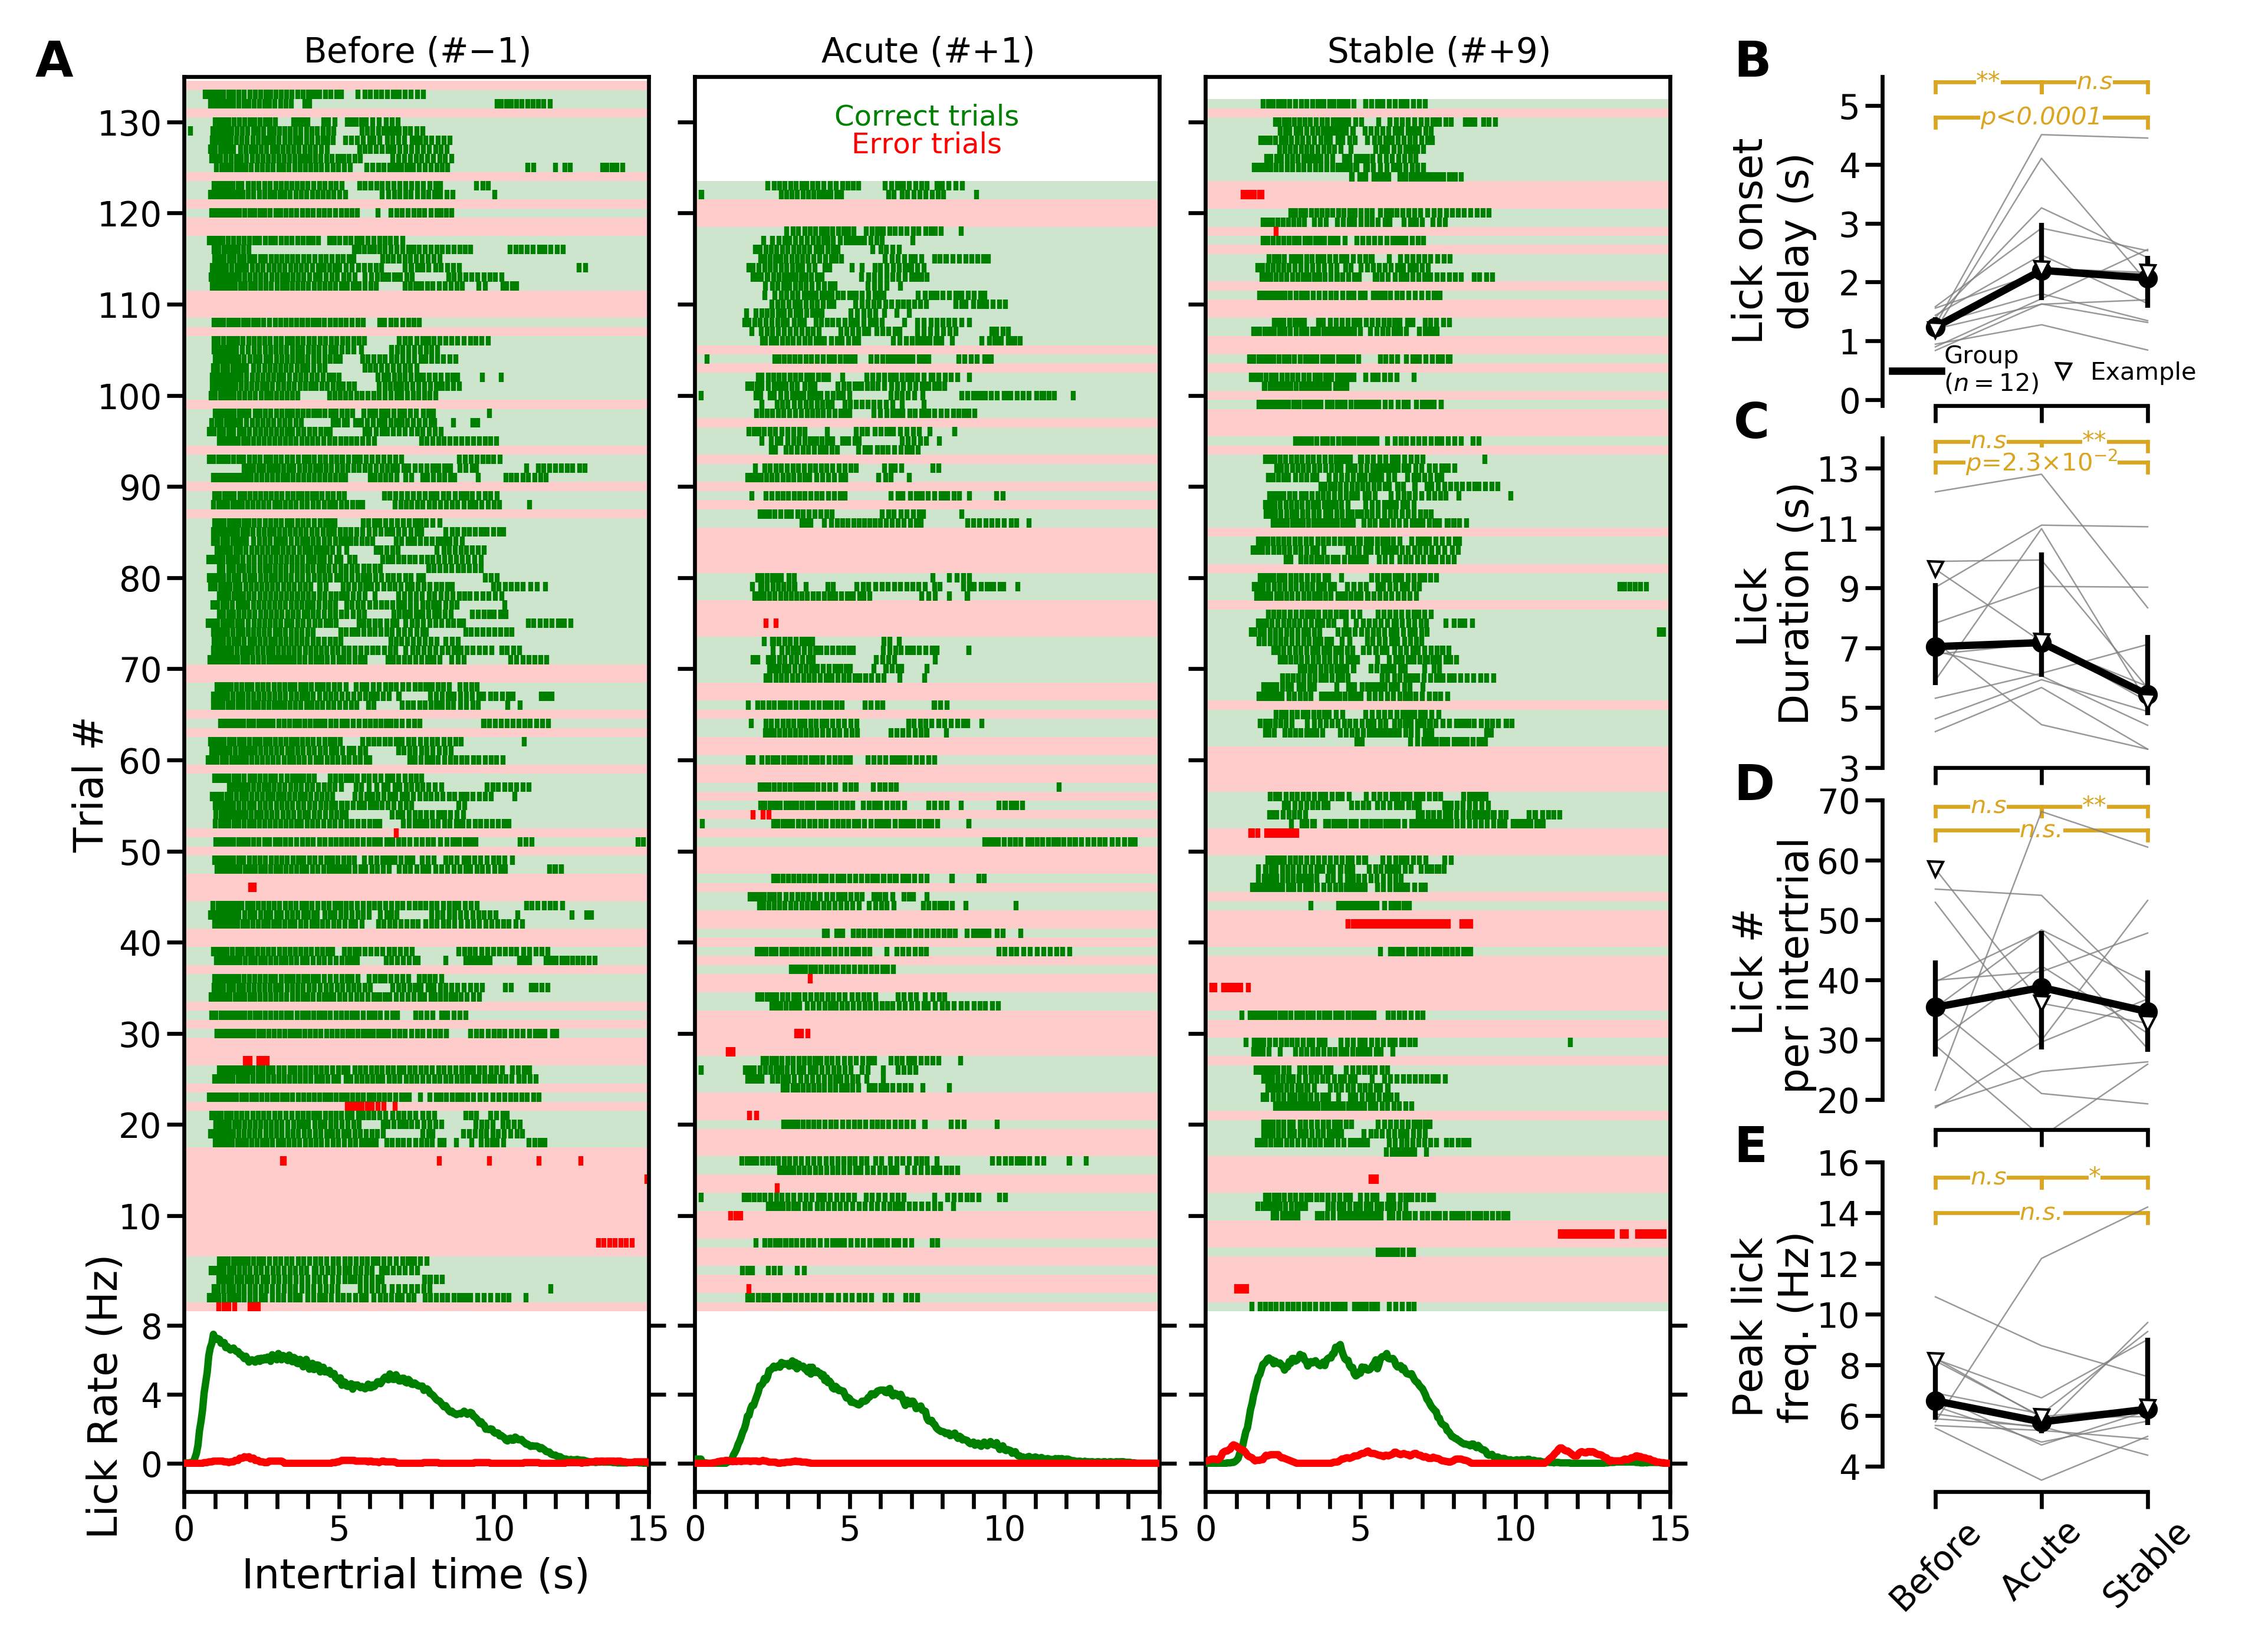

In [6]:
if "__file__" not in dir():
    plt.close('all')
    set_rc_params()
    figsize=(6,4)
    fig=plt.figure(figsize=figsize,dpi=600)
    
        
    
    

    ##########################################
    # 3: plot single session trajectories
    gs3= fig.add_gridspec(nrows=1, ncols=3, left=0.0, bottom=0, right=.7, top=1, wspace=.1)
    ax3L= fig.add_subplot(gs3[0])
    ax3M= fig.add_subplot(gs3[1])
    ax3R= fig.add_subplot(gs3[2])
    
    insetAx3L=plot_lick_raster_animal(root,session3Before, axes=ax3L)
    plot_lick_raster_animal(root,session3After, axes=ax3M)
    plot_lick_raster_animal(root,session3Final, axes=ax3R)

    ax3M.text(7.5,129,'Correct trials',
         va='bottom',ha='center',fontsize='xx-small', color='g')
    ax3M.text(7.5,129,'Error trials',
         va='top',ha='center',fontsize='xx-small', color='r')


    ax3L.set_title('Before (#$-1$)',fontsize='x-small')
    ax3M.set_title('Acute (#$+1$)',fontsize='x-small')
    ax3R.set_title('Stable (#$+9$)',fontsize='x-small')
    ax3L.set_ylabel('Trial #',labelpad=-3)
    ax3L.set_xlabel('Intertrial time (s)')
    ax3L.set_yticklabels(range(10,135,10))
    insetAx3L.set_yticklabels([0,4,8])
    insetAx3L.set_ylabel('Lick Rate (Hz)',labelpad=3)




    ##########################################
    # 4: 
    gs4= fig.add_gridspec(nrows=4, ncols=1, left=.8, bottom=0, right=.95, top=1, hspace=.1)
    ax4= fig.add_subplot(gs4[0])
    
    data4,animalList4=plot_event_1on1(root, ax4, Profiles4, colorCode=ColorCode, goodAnimals=goodAnimals4,
                                      x_pos=(1,2,3),TaskParamToPlot=TaskParamToPlot4, nPre=preSlice4, nPost=postSlice4,nFin=finSlice4)

    
    Eline=ax4.plot((1,2,3),data4[animalList4.index(session3Before[:6]),:],'v',
                   ms=3,mfc='white',mec='k',markeredgewidth=.5,zorder=50)
    
    
    ax4.legend([matplotlib.lines.Line2D([0,1], [0,1],color='k'),*Eline],
               [f'Group\n($n={len(animalList4)}$)','Example'],
               loc=(0,0), ncol=2, fontsize=5,frameon=False,markerscale=1,columnspacing=0,handletextpad=.1)


    ax4.set_ylim([-.1,5.5])
#     ax4.spines['left'].set_bounds(0,5)
    ax4.set_yticks(np.arange(0,6))
    ax4.set_ylabel('Lick onset\ndelay (s)',labelpad=0)
    ax4.set_xticklabels([])
    
    
    #STATS
    p4,s4=bootstrapTest(data4[:,-1]-data4[:,0])
    permtest.plotSigPair(ax4,y=4.8,x=(1,3), s=s4, color=colorSig,lw=.8)
    
    
    p4_,_=bootstrapTest(data4[:,0]-data4[:,1])
    s='**' if p4_<.001 else '*' 
    s=s if p4_<.01 else 'n.s'
    permtest.plotSigPair(ax4,y=5.4,x=(1,2), s=s, color=colorSig,lw=.8)

    p4__,_=bootstrapTest(data4[:,1]-data4[:,2])
    s='**' if p4__<.001 else '*' 
    s=s if p4__<.01 else 'n.s'
    permtest.plotSigPair(ax4,y=5.4,x=(2,3), s=s, color=colorSig,lw=.8)


    

    ##########################################
    # 4.5: 
    ax4_= fig.add_subplot(gs4[1])
    
    data4_,animalList4_=plot_event_1on1(root, ax4_, Profiles4, colorCode=ColorCode, goodAnimals=goodAnimals4,
                                        x_pos=(1,2,3),TaskParamToPlot=TaskParamToPlot4_, 
                                        nPre=preSlice4, nPost=postSlice4,nFin=finSlice4)

    
    ax4_.plot((1,2,3),data4_[animalList4_.index(session3Before[:6]),:],'v',
                   ms=3,mfc='white',mec='k',markeredgewidth=.5,zorder=50)
    
    

    ax4_.set_ylim([3,14])
    ax4_.spines['left'].set_bounds(3,14)
    ax4_.set_yticks(np.arange(3,14,2))
    ax4_.set_ylabel('Lick\nDuration (s)',labelpad=0)
    ax4_.set_xticklabels([])
    
    
    #STATS
    _p4,_s4=bootstrapTest(data4_[:,-1]-data4_[:,0])
    permtest.plotSigPair(ax4_,y=13.2,x=(1,3), s=_s4, color=colorSig,lw=.8)

    
    _p4_,_=bootstrapTest(data4_[:,0]-data4_[:,1])
    s='**' if _p4_<.001 else '*' 
    s=s if _p4_<.01 else 'n.s'
    permtest.plotSigPair(ax4_,y=13.9,x=(1,2), s=s, color=colorSig,lw=.8)

    _p4__,_=bootstrapTest(data4_[:,1]-data4_[:,2])
    s='**' if _p4__<.001 else '*' 
    s=s if _p4__<.01 else 'n.s'
    permtest.plotSigPair(ax4_,y=13.9,x=(2,3), s=s, color=colorSig,lw=.8)

    
    
    ##########################################
    # 5: 
    ax5= fig.add_subplot(gs4[2])
    
    data5,animalList5=plot_event_1on1(root, ax5, Profiles4, colorCode=ColorCode, goodAnimals=goodAnimals4,
                                      x_pos=(1,2,3),TaskParamToPlot=TaskParamToPlot5,
                                      nPre=preSlice4, nPost=postSlice4,nFin=finSlice4)

    ax5.plot((1,2,3),data5[animalList5.index(session3Before[:6]),:],'v',
             ms=3,mfc='white',mec='k',markeredgewidth=.5,zorder=50)

    
    ax5.set_ylim([15,70])
    ax5.spines['left'].set_bounds(20,70)
    ax5.set_yticks(np.arange(20,72,10))
    ax5.set_ylabel('Lick # \nper intertrial',labelpad=0)
    ax5.set_xticklabels([])

    #STATS
    p5,s5=bootstrapTest(data5[:,-1]-data5[:,0])
    permtest.plotSigPair(ax5,y=65,x=(1,3), s=s5, color=colorSig,lw=.8)
    
    
    p5_,_=bootstrapTest(data5[:,0]-data5[:,1])
    s='**' if p5_<.001 else '*' 
    s=s if p5_<.01 else 'n.s'
    permtest.plotSigPair(ax5,y=69,x=(1,2), s=s, color=colorSig,lw=.8)

    p5__,_=bootstrapTest(data5[:,1]-data4[:,2])
    s='**' if p5__<.001 else '*' 
    s=s if p5__<.01 else 'n.s'
    permtest.plotSigPair(ax5,y=69,x=(2,3), s=s, color=colorSig,lw=.8)



    ##########################################
    # 5: 
    ax6= fig.add_subplot(gs4[3])
    
    data6,animalList6=plot_event_1on1(root, ax6, Profiles4, colorCode=ColorCode, goodAnimals=goodAnimals4,
                                      x_pos=(1,2,3),TaskParamToPlot=TaskParamToPlot6,
                                      nPre=preSlice4, nPost=postSlice4,nFin=finSlice4)

    ax6.plot((1,2,3),data6[animalList6.index(session3Before[:6]),:],'v',
             ms=3,mfc='white',mec='k',markeredgewidth=.5,zorder=50)

    
    ax6.set_ylim([3,16])
    ax6.spines['left'].set_bounds(4,16)
    ax6.set_yticks(np.arange(4,17,2))
    ax6.set_ylabel('Peak lick\nfreq. (Hz)',labelpad=0)


    #STATS
    p6,s6=bootstrapTest(data6[:,-1]-data6[:,0])
    permtest.plotSigPair(ax6,y=14,x=(1,3), s=s6, color=colorSig,lw=.8)

    
    p6_,_=bootstrapTest(data6[:,0]-data6[:,1])
    s='**' if p6_<.001 else '*' 
    s=s if p6_<.01 else 'n.s'
    permtest.plotSigPair(ax6,y=15.4,x=(1,2), s=s, color=colorSig,lw=.8)

    p6__,_=bootstrapTest(data6[:,1]-data6[:,2])
    s='**' if p6__<.001 else '*' 
    s=s if p6__<.01 else 'n.s'
    permtest.plotSigPair(ax6,y=15.4,x=(2,3), s=s, color=colorSig,lw=.8)


    
    fig.align_ylabels([ax4,ax4_,ax5,ax6])
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    AXES=(ax3L,ax4,ax4_,ax5,ax6)
    OFFX=np.array([.07]*len(AXES))
    OFFY=np.array([.01]*len(AXES))
#     OFFX[0]=.02
#     OFFY[0]=.05
#     OFFY[1]=.1
    
    add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)
    
    fig.savefig(os.path.join(os.path.dirname(os.getcwd()),'LesionPaper','Figures','Lick.pdf'),
                format='pdf', bbox_inches='tight')
    
    plt.show()
    plt.close('all')
    matplotlib.rcdefaults()